In [73]:
from functools import partial
import numpy as np
import h5py
from unyt import Msun, Myr, Angstrom, erg, s, Hz, yr, h
from astropy.cosmology import LambdaCDM
import pandas as pd
from astropy.io import fits
from schwimmbad import MultiPool
from uncertainties import unumpy
from scipy import integrate

from synthesizer.grid import Grid
from synthesizer.particle import Galaxy
from synthesizer.instruments.filters import FilterCollection

from synthesizer.emission_models import PacmanEmission, BimodalPacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw, Calzetti2000, GrainsWD01
from synthesizer.emissions.utils import (
    Ha,
    Hb, 
    O2b,
    O2r,
    O3r,
    O3b,
    O3,
)
from synthesizer.conversions import lnu_to_absolute_mag

np.random.seed(680010)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from utilities import binned_weighted_quantile, calc_line_corr, calc_line_corr_from_Av, get_flares_LF

cosmo = LambdaCDM(Om0=0.307, Ode0=0.693, H0=67.77, Ob0=0.04825)

In [74]:
def Ha_to_SFR(Ha):
    
    sfr = 10**(-41.36) * Ha
    
    return sfr

def get_data(ii, tag):

    num = str(ii)

    if len(num) == 1:
        num =  '0'+num

    sim = "./data/flares_sfe_data.hdf5"
    num = num+'/'

    with h5py.File(sim, 'r') as hf:
        Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
        MassweightedZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('CurrentMassWeightedStellarZ'), dtype = np.float32)
        MFUVatt = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('FUV'), dtype = np.float32) * erg / s / Hz
        MFUVint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('FUV'), dtype = np.float32) * erg / s / Hz

        Av = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('V'), dtype = np.float32) / np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('V'), dtype = np.float32)
        Av = -2.5 * np.log10(Av)

        Halpha = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbeta = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('Luminosity'), dtype = np.float64)
        Halphaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbetaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI4861'].get('Luminosity'), dtype = np.float64)      


    ok = (Halphaint>0) * (lnu_to_absolute_mag(MFUVatt)<-17)

    return Mstar[ok], MFUVatt[ok], Halpha[ok], Hbeta[ok], Halphaint[ok], Hbetaint[ok], MassweightedZ[ok], MFUVint[ok], Av[ok]

In [75]:
# Define the grid
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps"
grid_dir = "./data/" 
grid = Grid(grid_name, grid_dir=grid_dir)

Zsun = 0.014
req_lines = {'H 1 6562.80A': 'Halpha',
             'H 1 4861.32A': 'Hbeta',
             'O 2 3726.03A,O 2 3728.81A': '[OII]3727,29',
             'O 3 4958.91A': '[OIII]4959',
             'O 3 5006.84A': '[OIII]5007',
             'Ne 3 3868.76A': 'NeIII3869'
}

tophats = {
    "UV1500": {"lam_eff": 1500*Angstrom, "lam_fwhm": 300*Angstrom},
    "UV2800": {"lam_eff": 2800*Angstrom, "lam_fwhm": 300*Angstrom},
}

filters = FilterCollection(
    filter_codes=[f'Generic/Johnson.V'],
    tophat_dict=tophats,
    new_lam=grid.lam
)

li = [
       Ha,
       Hb, 
   ]

lam_Ha = 6562.80 * Angstrom
lam_Hb = 4861.32 * Angstrom

In [76]:
redshift = 6.
# Number of star particles
n = 100
ages = np.random.uniform(1, 30, size=n) * Myr
Z = 10**np.random.uniform(-3, -2, size=n)
mass = 1e6*np.random.uniform(1, 5, n) * Msun 

print (r'log$_{10}$(M$_{\star}$/M$_{\odot}$): ', np.log10(np.sum(mass).to('Msun')))

# Dust distributions
max_tau = 15
mu, sigma = 0.1, 0.2
nsigma = np.arange(0,max_tau,2)
num_gals = len(nsigma)

# Property holders
logOH = np.zeros(4)
lum_int = np.zeros(4, dtype=object)
line_int = np.zeros(4, dtype=object)
sed_int = np.zeros(4, dtype=object)

line_emergent = np.zeros((4, num_gals), dtype=object)
sed_emergent = np.zeros((4, num_gals), dtype=object)
lum_att = np.zeros((4, num_gals))
att_curve = np.zeros((4, num_gals, len(grid.lam)))
Av = np.zeros((4, num_gals))
#intrinsic
Luv = np.zeros(4)
Halpha_frac_dust = np.zeros((4, num_gals))
Halpha_frac_Avcorr = np.zeros((4, num_gals))
Halpha_frac_balmercorr = np.zeros((4, num_gals))

# Vary everything
gal = Galaxy(redshift=redshift)
gal.load_stars(
    ages=ages,
    metallicities=Z,
    initial_masses=mass 
)
ok = gal.stars.ages<=10*Myr
Zmean = np.sum(gal.stars.initial_masses[ok] * gal.stars.metallicities[ok]) / np.sum(gal.stars.initial_masses[ok])
Agemean = np.sum(gal.stars.initial_masses[ok] * gal.stars.ages[ok]) / np.sum(gal.stars.initial_masses[ok])

print (Zmean, Agemean)

# Keep everything fixed
gal_const = Galaxy(redshift=redshift)
gal_const.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary age
gal_vary_age = Galaxy(redshift=redshift)
gal_vary_age.load_stars(
    ages=ages,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary metallicity
gal_vary_Z = Galaxy(redshift=redshift)
gal_vary_Z.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=Z,
    initial_masses=mass 
)

all_gals = [gal_const, gal_vary_age, gal_vary_Z, gal]

for jj, kk in enumerate(all_gals):
    print ("Galaxy number: ", jj)
    ok = kk.stars.ages<=10*Myr
    Zmean = np.sum(kk.stars.initial_masses[ok] * kk.stars.metallicities[ok]) / np.sum(kk.stars.initial_masses[ok])    
    logOH[jj] = 8.69 + np.log10(Zmean/Zsun)

    for ii in range(num_gals):
        tau_v = mu + np.random.normal(0, nsigma[ii], n)
        tau_v[tau_v<0] = 0.01
        emodel = PacmanEmission(
            grid=grid,
            tau_v=tau_v,
            dust_curve=PowerLaw(),
            per_particle=True
        )   
    
        kk.stars.get_spectra(emission_model=emodel)    
        kk.stars.get_lines(li,
            emodel
        )        
        
        line_emergent[jj][ii] = kk.stars.lines['emergent']
        kk.stars.spectra['emergent'].get_fnu(cosmo=cosmo, z=redshift)   
        tmp = kk.stars.spectra['emergent'].get_photo_lnu(filters, verbose=False)
        lum_att[jj][ii] = tmp['Generic/Johnson.V']
        
        sed_emergent[jj][ii] = kk.stars.spectra['emergent']
        att_curve[jj][ii] = -2.5 * np.log10(kk.stars.spectra['emergent'].luminosity/kk.stars.spectra['intrinsic'].luminosity)

    line_int[jj] = kk.stars.lines['intrinsic']    
    lum_int[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['Generic/Johnson.V']    
    Luv[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['UV1500'] 
    sed_int[jj] = kk.stars.spectra['intrinsic']

    Av[jj] = -2.5 * np.log10(lum_att[jj]/lum_int[jj])
    
for jj, kk in enumerate(all_gals):
    for ii in range(num_gals):
        Halpha_frac_dust[jj][ii] = line_emergent[jj][ii]['Ha'].luminosity / line_int[jj]['Ha'].luminosity
        
        Halpha_frac_Avcorr[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, Av[jj][ii], slope=0) / line_int[jj]['Ha'].luminosity
        
        Halpha_frac_balmercorr[jj][ii] = calc_line_corr(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity) / line_int[jj]['Ha'].luminosity

log$_{10}$(M$_{\star}$/M$_{\odot}$):  8.481938530547351
0.0043673333344749635 dimensionless 5268099.2695223 yr
Galaxy number:  0


/Users/ap629AA/Astro/synthesizer/synthesizer/src/synthesizer/particle/galaxy.py:260: RuntimeWarning: Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  self.calculate_integrated_stellar_properties()
/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


Galaxy number:  1
Galaxy number:  2
Galaxy number:  3


/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1824: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_8259/2256677506.py:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Halpha_frac_dust[jj][ii] = line_emergent[jj][ii]['Ha'].luminosity / line_int[jj]['Ha'].luminosity
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_8259/2256677506.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Halpha_frac_Avcorr[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha

In [77]:
# Star formation and metal enrichment history
title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']
for jj, kk in enumerate(all_gals):
    kk.stars.get_sfzh(log10ages=np.arange(6,7.51,0.1), log10metallicities=np.arange(-3.5,-1.4,0.5))
    fig, ax = kk.stars.plot_sfzh(show=False)
    ax.xaxis.label.set_size(13)
    ax.yaxis.label.set_size(13)
    if jj>0:
        ax.set_ylabel('')
    fig.suptitle(title[jj], fontsize=13)
    fig.savefig(F'plots/sfzh_{jj}.png', bbox_inches='tight', dpi=300)
    plt.close()
    

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_8259/559827656.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_8259/559827656.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']


In [78]:
logOH

array([8.1840883 , 8.1840883 , 8.13182314, 8.1840883 ])

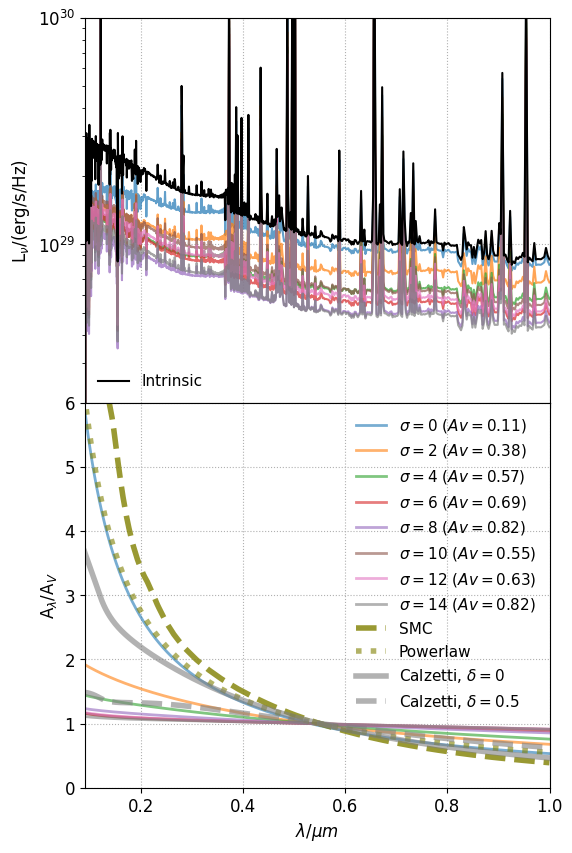

In [79]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(6, 10), sharex=True, sharey=False, facecolor='w', edgecolor='k')
axs = axs.ravel()

req_gal = 0

req_sed = sed_emergent[req_gal]
req_att_curve = att_curve[req_gal]
req_Av = Av[req_gal]

for ii in range(num_gals):
    color = plt.cm.tab10(ii) 
    ok = np.where(grid.lam<=1e4 * Angstrom)[0]
    
    axs[0].plot(grid.lam[ok]/1e4, req_sed[ii].lnu[ok], color=color, alpha=0.7)
    axs[1].plot(grid.lam[ok]/1e4, req_att_curve[ii][ok]/req_Av[ii], label=rF'$\sigma={nsigma[ii]}$ $(Av={np.round(Av[0][ii],2)})$', alpha=0.6, lw=2, color=color)    

axs[0].plot(grid.lam[ok]/1e4, sed_int[req_gal].lnu[ok], color='black', label='Intrinsic')

c = GrainsWD01(model='SMC')
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='SMC', alpha=0.8, ls='dashed', lw=4, color='olive')

c = PowerLaw()
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='Powerlaw', alpha=0.6, ls='dotted', lw=4, color='olive')

c = Calzetti2000()
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label=r'Calzetti, $\delta=0$', alpha=0.6, ls='solid', lw=4, color='grey')

c = Calzetti2000(slope=0.5)
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label=r'Calzetti, $\delta=0.5$', alpha=0.6, ls='dashed', lw=4, color='grey')

for ax in axs:
    ax.grid(ls='dotted')
    ax.legend(frameon=False, fontsize=11) 
    ax.set_xlim(0.09,1)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
    
axs[0].set_ylabel(r'L$_{\nu}$/(erg/s/Hz)', fontsize=12)
axs[0].set_ylim(2e28, 1e30)
axs[0].set_yscale('log')

axs[1].set_xlabel(r'$\lambda$/$\mu m$', fontsize=12)
axs[1].set_ylim(0,6)
axs[1].set_ylabel(r'A$_{\lambda}$/A$_{V}$', fontsize=12)

fig.subplots_adjust(hspace=0,wspace=0)   
plt.savefig('plots/toy_att_curves.png', dpi=300, bbox_inches='tight')   
plt.show()

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_8259/3186203925.py:32: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=11, loc="upper right", ncols=2, framealpha=0.4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_8259/3186203925.py:32: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=11, loc="upper right", ncols=2, framealpha=0.4)


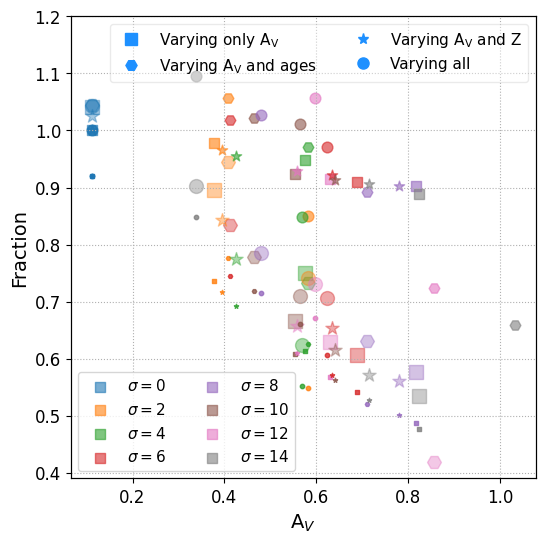

In [80]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(6,6), sharex=True, sharey=True, facecolor='w', edgecolor='k')
twinax = ax.twinx()

markers = ['s', 'H', '*', 'o']
custom = [Line2D([], [], marker=ii, markersize=8, color='dodgerblue', linestyle='None') for ii in markers]

for jj in range(4):    
    for ii in range(num_gals):
        color = plt.cm.tab10(ii)
        
      
        ax.scatter(Av[jj][ii], Halpha_frac_dust[jj][ii], color=color, s=10, marker=markers[jj], alpha=0.8)
        
        if jj==0:
            ax.scatter(Av[jj][ii], Halpha_frac_Avcorr[jj][ii], color=color, s=60, marker=markers[jj], alpha=0.6, label=rF'$\sigma={nsigma[ii]}$')
        else:
            ax.scatter(Av[jj][ii], Halpha_frac_Avcorr[jj][ii], color=color, s=60, marker=markers[jj], alpha=0.6)
            
        ax.scatter(Av[jj][ii], Halpha_frac_balmercorr[jj][ii], color=color, s=100, marker=markers[jj], alpha=0.4)


ax.set_xlabel(r'A$_{V}$', fontsize=14)
ax.set_ylabel(r'Fraction', fontsize=14)
ax.set_ylim(0.39, 1.2)
ax.grid(ls='dotted')
ax.legend(frameon=True, fontsize=11, ncols=2, loc='lower left') 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
twinax.set_yticks([])
twinax.set_yticklabels([])

twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=True, fontsize=11, loc="upper right", ncols=2, framealpha=0.4)
twinax.set_yticks([])
twinax.set_yticklabels([])

plt.savefig('plots/toy_sfr_frac.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_8259/3358464488.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_8259/3358464488.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvq

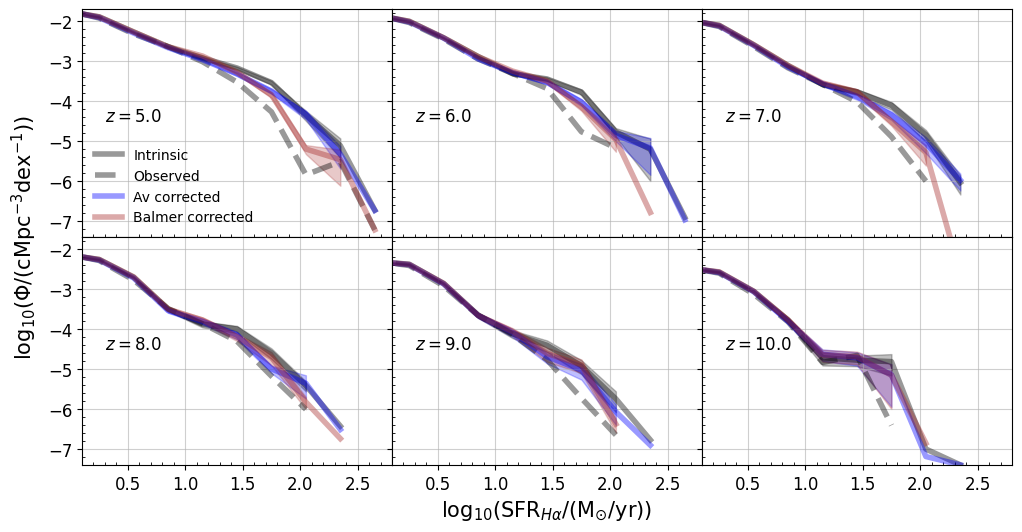

In [81]:
h = 0.6777
vol = (4/3)*np.pi*(14/h)**3
quantiles = [0.16,0.50,0.84]
df = pd.read_csv('./data/weights_grid.txt')
weights = np.array(df['weights'])

sfrbins = np.arange(-0.5, 3.3, 0.3)
bincen = (sfrbins[1:]+sfrbins[:-1])/2.
binwidth = sfrbins[1:] - sfrbins[:-1]

sfrbinshigh = np.arange(1.5, 3.3, 0.3)
bincenhigh = (sfrbinshigh[1:]+sfrbinshigh[:-1])/2.
binwidthhigh = sfrbinshigh[1:] - sfrbinshigh[:-1]

tags = ['010_z005p000', '009_z006p000', '008_z007p000', '007_z008p000', '006_z009p000', '005_z010p000']

obsc_frac = np.zeros((2, len(tags)))
obsc_frac_err = np.zeros((2, len(tags)))

sfrd_frac_Av = np.zeros((2, len(tags)))
sfrd_frac_Av_err = np.zeros((2, len(tags)))

sfrd_frac_balmer = np.zeros((2, len(tags)))
sfrd_frac_balmer_err = np.zeros((2, len(tags)))

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 6), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs = axs.ravel()

for ii, tag in enumerate(tags):
       
    z = float(tag[5:].replace('p','.'))

    func    = partial(get_data, tag=tag)
    pool    = MultiPool(processes=4)
    dat     = np.array(list(pool.map(func, np.arange(0,40))), dtype='object')
    pool.close()

    Mstar = np.log10(np.concatenate(dat[:,0]))
    MFUVatt = np.concatenate(dat[:,1])
    Halpha = np.concatenate(dat[:,2])
    Hbeta = np.concatenate(dat[:,3])
    Halphaint = np.concatenate(dat[:,4])
    Hbetaint = np.concatenate(dat[:,5])
    MassweightedZ = np.concatenate(dat[:,6])
    MFUVint = np.concatenate(dat[:,7])
    Av = np.concatenate(dat[:,8])
    
    Halpha_Av = calc_line_corr_from_Av(Halpha * erg/s, lam_Ha, Av, slope=0).to_value()
    Halpha_balmer =  calc_line_corr(Halpha * erg/s, lam_Ha, Halpha/Hbeta, slope=0).to_value() 
    
    sfr_int = np.log10(Ha_to_SFR(Halphaint))
    sfr_dust = np.log10(Ha_to_SFR(Halpha))
    sfr_Av = np.log10(Ha_to_SFR(Halpha_Av))
    sfr_balmer = np.log10(Ha_to_SFR(Halpha_balmer))
    
    tot_gals = len(Mstar)
    
    n = np.array([])
    for jj in range(40):
        n = np.append(n, len(dat[jj][0]))

    #Make the SFR distribution function, integrate the different ratio to get the recovered fraction
   
    hist, M, err = get_flares_LF(sfr_int, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='solid', label='Intrinsic', color='black')
    axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='black')
    tot = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincen)
    
    hist, M, err = get_flares_LF(sfr_int, weights, sfrbinshigh, n)
    phi, phierr = M/(binwidthhigh*vol), err/(binwidthhigh*vol)
    tothigh = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincenhigh)
    
    
    hist, M, err = get_flares_LF(sfr_dust, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='dashed', label='Observed', color='black')
    # axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='black')
    tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincen) / tot
    obsc_frac[0][ii] = unumpy.nominal_values(tmp)
    obsc_frac_err[0][ii] = unumpy.std_devs(tmp)
        
    hist, M, err = get_flares_LF(sfr_dust, weights, sfrbinshigh, n)
    phi, phierr = M/(binwidthhigh*vol), err/(binwidthhigh*vol)
    tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincenhigh) / tothigh
    obsc_frac[1][ii] = unumpy.nominal_values(tmp)
    obsc_frac_err[1][ii] = unumpy.std_devs(tmp)
    
    
    hist, M, err = get_flares_LF(sfr_Av, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='solid', label='Av corrected', color='blue')
    axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='blue')
    tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincen) / tot
    sfrd_frac_Av[0][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_Av_err[0][ii] = unumpy.std_devs(tmp)
        
    hist, M, err = get_flares_LF(sfr_Av, weights, sfrbinshigh, n)
    phi, phierr = M/(binwidthhigh*vol), err/(binwidthhigh*vol)
    tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincenhigh) / tothigh
    sfrd_frac_Av[1][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_Av_err[1][ii] = unumpy.std_devs(tmp)
    
    
    hist, M, err = get_flares_LF(sfr_balmer, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='solid', label='Balmer corrected', color='brown')
    axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='brown')
    tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincen) / tot
    sfrd_frac_balmer[0][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_balmer_err[0][ii] = unumpy.std_devs(tmp)
        
    hist, M, err = get_flares_LF(sfr_balmer, weights, sfrbinshigh, n)
    phi, phierr = M/(binwidthhigh*vol), err/(binwidthhigh*vol)
    tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincenhigh) / tothigh
    sfrd_frac_balmer[1][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_balmer_err[1][ii] = unumpy.std_devs(tmp)
    
    axs[ii].text(.3, -4.5, r'$z = {}$'.format(z), fontsize = 12)
    
for ax in axs:
    ax.grid(True, alpha=0.6)
    ax.set_xlim(0.1, 2.8)
    ax.set_ylim(-7.4, -1.7)
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor', direction='in')
    ax.tick_params(axis='y', which='minor', direction='in')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

axs[0].legend(frameon=False, fontsize=10)
axs[4].set_xlabel(r'log$_{10}$($\mathrm{SFR}_{H\alpha}$/(M$_{\odot}$/yr))', fontsize=15)

fig.subplots_adjust(bottom=0.12, wspace=0, hspace=0)

fig.text(0.065, 0.5, r'log$_{10}$($\Phi$/($\mathrm{cMpc}^{-3}\mathrm{dex}^{-1}$))', va='center', rotation='vertical', fontsize=15)

plt.savefig('plots/sfr_function.png', dpi=300, bbox_inches='tight')

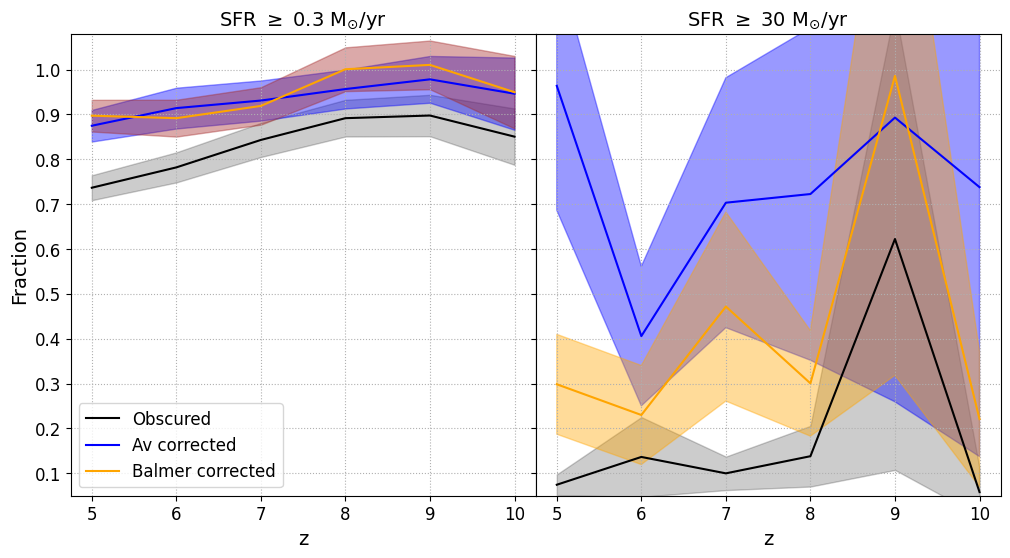

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 6), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs = axs.ravel()

zs = np.arange(5,11,1)

axs[0].plot(zs, obsc_frac[0], color='black', label='Obscured')
axs[0].fill_between(zs, obsc_frac[0] - obsc_frac_err[0], obsc_frac[0] + obsc_frac_err[0], alpha=0.2, color='black')

axs[0].plot(zs, sfrd_frac_Av[0], color='blue', label='Av corrected')
axs[0].fill_between(zs, sfrd_frac_Av[0] - sfrd_frac_Av_err[0], sfrd_frac_Av[0] + sfrd_frac_Av_err[0], alpha=0.4, color='blue')

axs[0].plot(zs, sfrd_frac_balmer[0], color='orange', label='Balmer corrected')
axs[0].fill_between(zs, sfrd_frac_balmer[0] - sfrd_frac_balmer_err[0], sfrd_frac_balmer[0] + sfrd_frac_balmer_err[0], alpha=0.4, color='brown')

axs[1].plot(zs, obsc_frac[1], color='black')
axs[1].fill_between(zs, obsc_frac[1] - obsc_frac_err[1], obsc_frac[1] + obsc_frac_err[1], alpha=0.2, color='black')

axs[1].plot(zs, sfrd_frac_Av[1], color='blue')
axs[1].fill_between(zs, sfrd_frac_Av[1] - sfrd_frac_Av_err[1], sfrd_frac_Av[1] + sfrd_frac_Av_err[1], alpha=0.4, color='blue')

axs[1].plot(zs, sfrd_frac_balmer[1], color='orange')
axs[1].fill_between(zs, sfrd_frac_balmer[1] - sfrd_frac_balmer_err[1], sfrd_frac_balmer[1] + sfrd_frac_balmer_err[1], alpha=0.4, color='orange')

axs[0].legend(fontsize=12, frameon=True)

for ax in axs:
    ax.grid(ls='dotted')
    ax.set_ylim(0.05, 1.08)
    ax.set_yticks(np.arange(0.1, 1.1, 0.1))
    ax.set_xlabel('z', fontsize=14)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

axs[0].set_ylabel('Fraction', fontsize=14)
axs[0].set_title(r'SFR $\geq$ 0.3 M$_{\odot}$/yr', fontsize=14)   
axs[1].set_title(r'SFR $\geq$ 30 M$_{\odot}$/yr', fontsize=14)   

fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('plots/sfrd_frac.png', dpi=300, bbox_inches='tight')

# Might need to fit with a schechter function and integrate